# AGH Modelling of Physical Systems Lab 3 (2025 March 18th)
Tomasz Makowski (makowskit@student.agh.edu.pl)

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pint import UnitRegistry
from open_atmos_jupyter_utils import show_plot

si = UnitRegistry()

In [3]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [4]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50

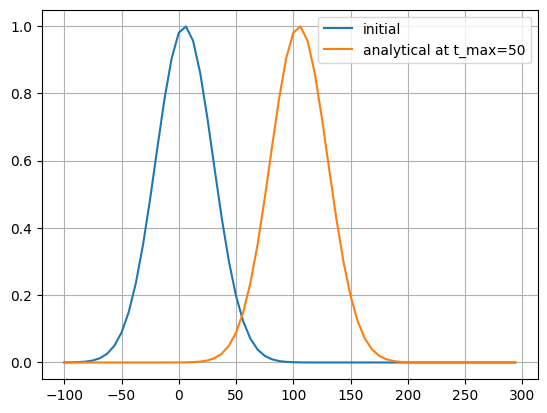

In [5]:
plt.plot(x, psi_0(x), label='initial')
plt.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
plt.legend()
plt.grid()

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [6]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __radd__(self, i): 
        return slice(i.start+1, i.stop+1)
    def __rsub__(self, i): 
        return slice(i.start-1, i.stop-1)

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [7]:
i = slice(1,nx-2)
one = shift()

nt = 50
dt = t_max / nt
C = u * dt / dx

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [8]:
psi = psi_0(x)
for _ in range(nt):
    psi[i] = psi[i] - (
        F(psi[i    ], psi[i+one], C) -
        F(psi[i-one], psi[i    ], C) 
    )

**7. comparing analytic and numerical solutions**

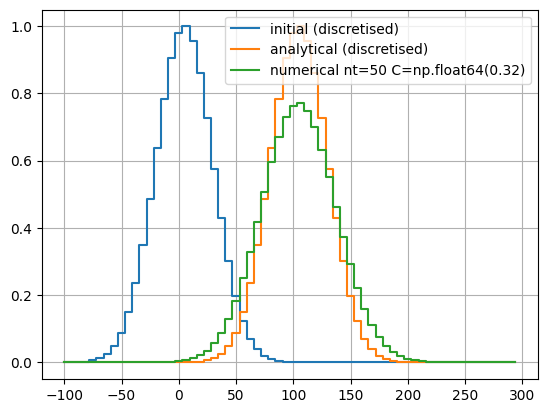

In [9]:
plt.step(x, psi_0(x), label='initial (discretised)', where='mid')
plt.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
plt.step(x, psi, label=f'numerical {nt=} {C=}', where='mid')
plt.legend()
plt.grid()

## Verification of Spatial Convergence for the Upwind Scheme

### Analysis Approach

In this analysis, the spatial convergence properties of the upwind scheme have been examined in the context of the one-dimensional linear advection equation. The primary objective was to quantify how the numerical accuracy is affected by the spatial resolution, as controlled by the grid spacing (Δx), while keeping other physical and numerical parameters constant.

A Gaussian-shaped initial condition was selected, and the scalar field was transported over a fixed spatial domain and time interval. The Courant number was held constant throughout each individual simulation in order to ensure consistent numerical stability and to isolate the influence of spatial discretization alone. The root mean square error (RMSE) between the numerical and analytical solutions was computed for a wide range of spatial step sizes, allowing the rate of convergence to be inferred and compared across different Courant number values.

In [10]:
def gaussian_profile(x, x0=5, amplitude=1, sigma=25):
    return amplitude * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2))

simulation_time = 50
domain_start = -100
domain_end = 300

In [11]:
def upwind_advection(x, velocity, courant, dx):
    field = gaussian_profile(x)
    dt = courant * dx / velocity
    steps = int(simulation_time / dt)
    result = np.copy(field)

    for _ in range(steps):
        updated = np.copy(result)
        updated[1:] = result[1:] - courant * (result[1:] - result[:-1])
        result = updated

    return result
 

In [12]:
def compute_rmse(numerical, reference):
    return np.sqrt(np.mean((numerical - reference) ** 2))


In [13]:
def evaluate_spatial_error(velocity, courant, dx_array):
    all_errors = []

    for dx in dx_array:
        nx = int((domain_end - domain_start) / dx)
        x = np.linspace(domain_start, domain_end, nx, endpoint=False)
        numerical_result = upwind_advection(x, velocity, courant, dx)
        analytical_result = gaussian_profile(x - velocity * simulation_time)
        error = compute_rmse(numerical_result, analytical_result)
        all_errors.append(error)

    return np.array(all_errors)


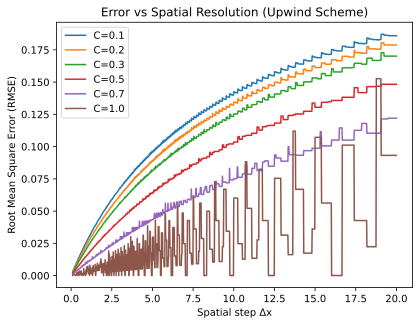

In [14]:
dx_range = np.linspace(0.1, 20, 1000)
adv_velocity = 3.0
courant_values = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

for c_value in courant_values:
    rmse_values = evaluate_spatial_error(adv_velocity, c_value, dx_range)
    plt.plot(dx_range, rmse_values, label=f'C={c_value:.1f}')

plt.xlabel('Spatial step Δx')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.title('Error vs Spatial Resolution (Upwind Scheme)')
plt.legend()
show_plot()

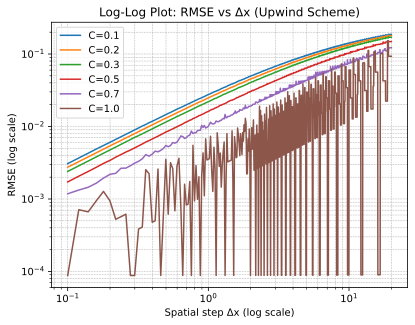

In [20]:
dx_range = np.linspace(0.1, 20, 1000)
adv_velocity = 3.0
courant_values = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

for c_value in courant_values:
    rmse_values = evaluate_spatial_error(adv_velocity, c_value, dx_range)
    plt.loglog(dx_range, rmse_values, label=f'C={c_value:.1f}')

plt.xlabel('Spatial step Δx (log scale)')
plt.ylabel('RMSE (log scale)')
plt.title('Log-Log Plot: RMSE vs Δx (Upwind Scheme)')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
show_plot()

### Conclusions

#### General

The spatial convergence characteristics of the upwind scheme have been examined through a systematic comparison of numerical and analytical solutions of the linear advection equation. The evaluation has been based on the root mean square error (RMSE) computed across a broad range of spatial discretization steps (Δx), with the Courant number held constant during each simulation.

It has been consistently observed that a reduction in Δx results in a decrease in RMSE, confirming the expected first-order accuracy of the method in space. This behavior has been maintained for all tested Courant numbers, indicating robustness of the convergence with respect to numerical stability constraints.

Nonetheless, the absolute magnitude and smoothness of the error have been found to depend on the specific value of the Courant number. For Courant numbers closer to unity, the error curves have shown increased irregularity, particularly for larger Δx values, while still achieving lower RMSE overall. In contrast, simulations conducted with smaller Courant numbers (e.g., 0.1 to 0.3) have produced smoother and more monotonic error curves, although the resulting RMSE values were noticeably higher across the full range of Δx.

This observation suggests a trade-off between numerical smoothness and overall accuracy. Simulations with high Courant numbers may deliver lower error magnitudes but at the cost of increased variability and potential instability, especially for coarse spatial grids. Conversely, low-C simulations tend to be more stable and predictable, though they introduce more numerical diffusion.

Therefore, it can be concluded that improved accuracy is achieved by refining the spatial grid, but diminishing returns are encountered beyond a certain resolution, implying that an optimal balance between computational cost and precision must be considered. Additionally, care must be taken when selecting the Courant number, as it has been shown to influence not only the stability but also the smoothness, predictability, and magnitude of the numerical error.

#### Analysis of log-log plot

The log-log plot of RMSE versus spatial step size Δx clearly demonstrates that the upwind scheme exhibits first-order spatial convergence for Courant numbers ranging from 0.1 to 0.7. The corresponding curves follow approximately linear trends with a slope close to one, indicating that the error decreases proportionally to the grid resolution.

For Courant number C = 1.0, the behavior differs significantly. Although the RMSE remains low for small Δx, the error curve exhibits strong irregularity and high-frequency fluctuations. This is attributed to the fact that C = 1.0 corresponds to the edge of the numerical stability limit, where no numerical diffusion is introduced by the scheme. As a result, even small numerical disturbances may accumulate and lead to oscillatory behavior, making the simulation less robust despite its theoretical accuracy.

